Importing the dataset and missing values

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("train.csv")


# a) Missing Values
null_counts = df.isnull().sum()
print(null_counts)

# b) Duplicate Entries
duplicate_count = df.duplicated().sum()
print(duplicate_count)

num_rows, num_cols = df.shape

# Print the results
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64
0
Number of rows: 1117957
Number of columns: 22


Histograms to show the distribution of values of every single feature. The height of each bar indicates the number of objects and a continuous curve that approximates the underlying probability density function of the data.




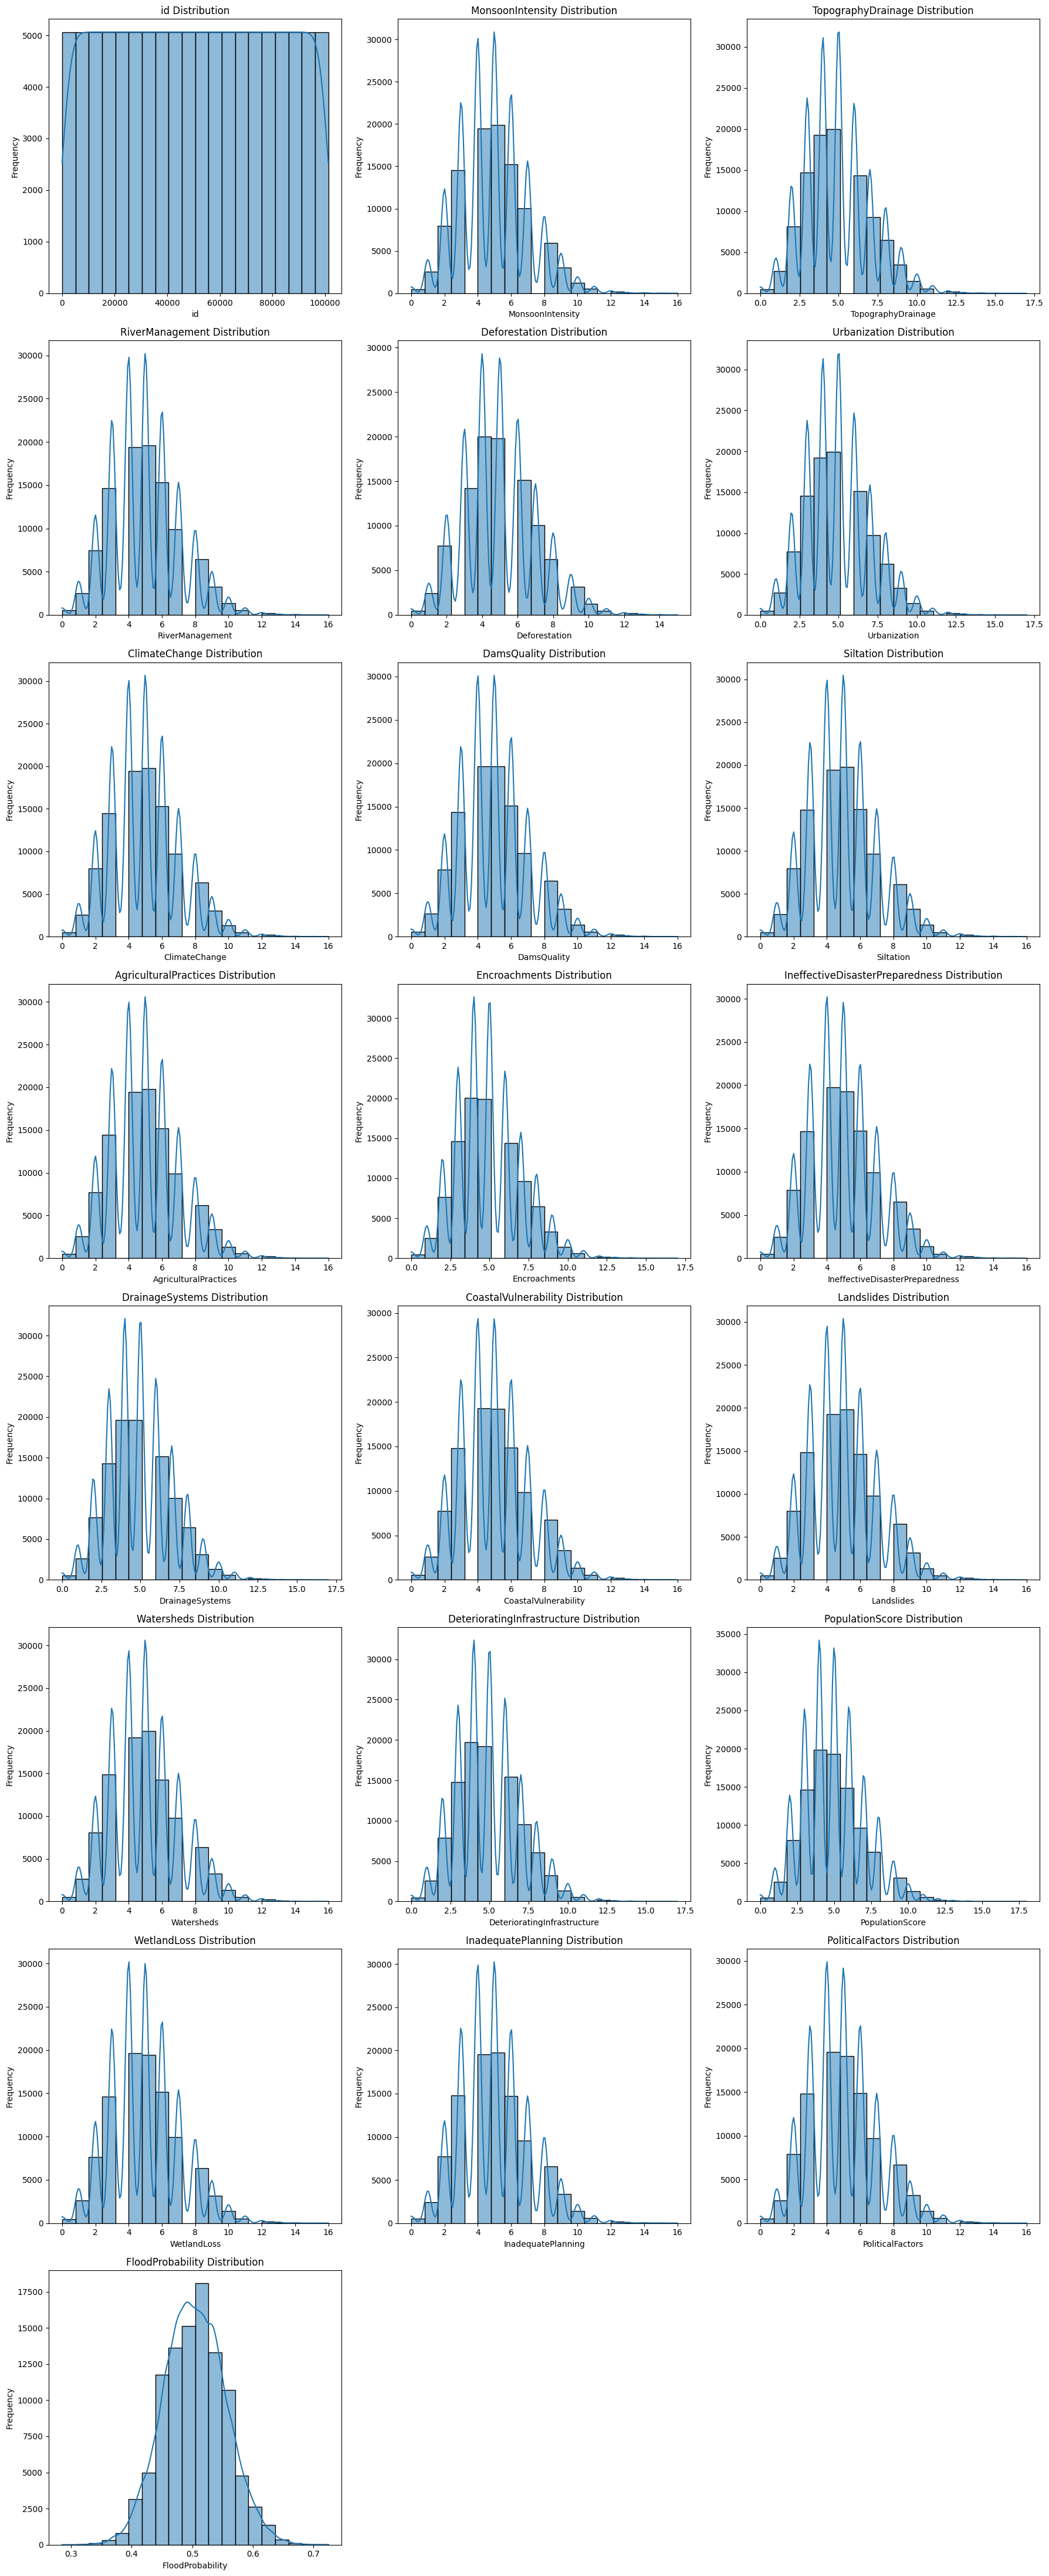

In [ ]:
# Select only numerical columns
num_features = df.select_dtypes(include=['float64', 'int64']).columns

# Plotting histograms for each numerical feature
fig, axes = plt.subplots(len(num_features) // 3 + 1, 3, figsize=(18, len(num_features) * 2))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.histplot(df[feature], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f"{feature} Distribution")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

# Hide any extra axes if the number of features is not a multiple of 3
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

Correlation Matrix of the Dataset

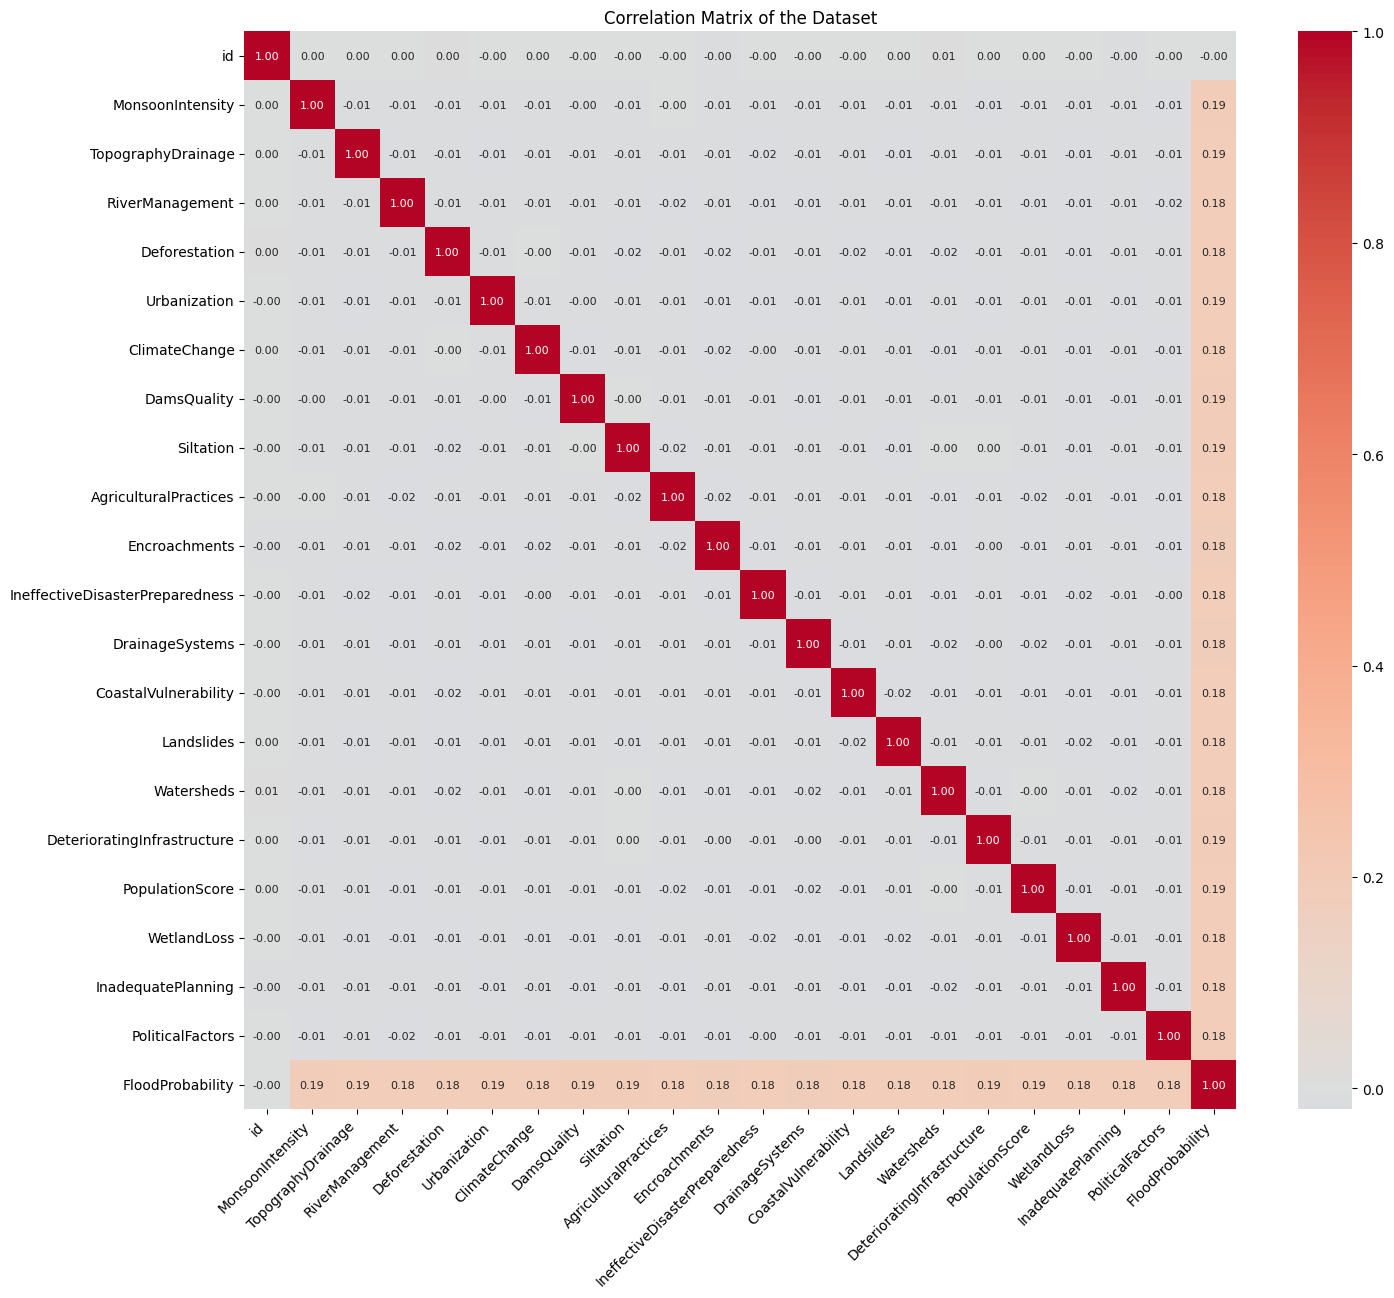

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 14))  # Increase the figure size
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            annot_kws={"size": 8})  # Reduce annotation font size
plt.title("Correlation Matrix of the Dataset")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.show()


Box plots for knowing outliers

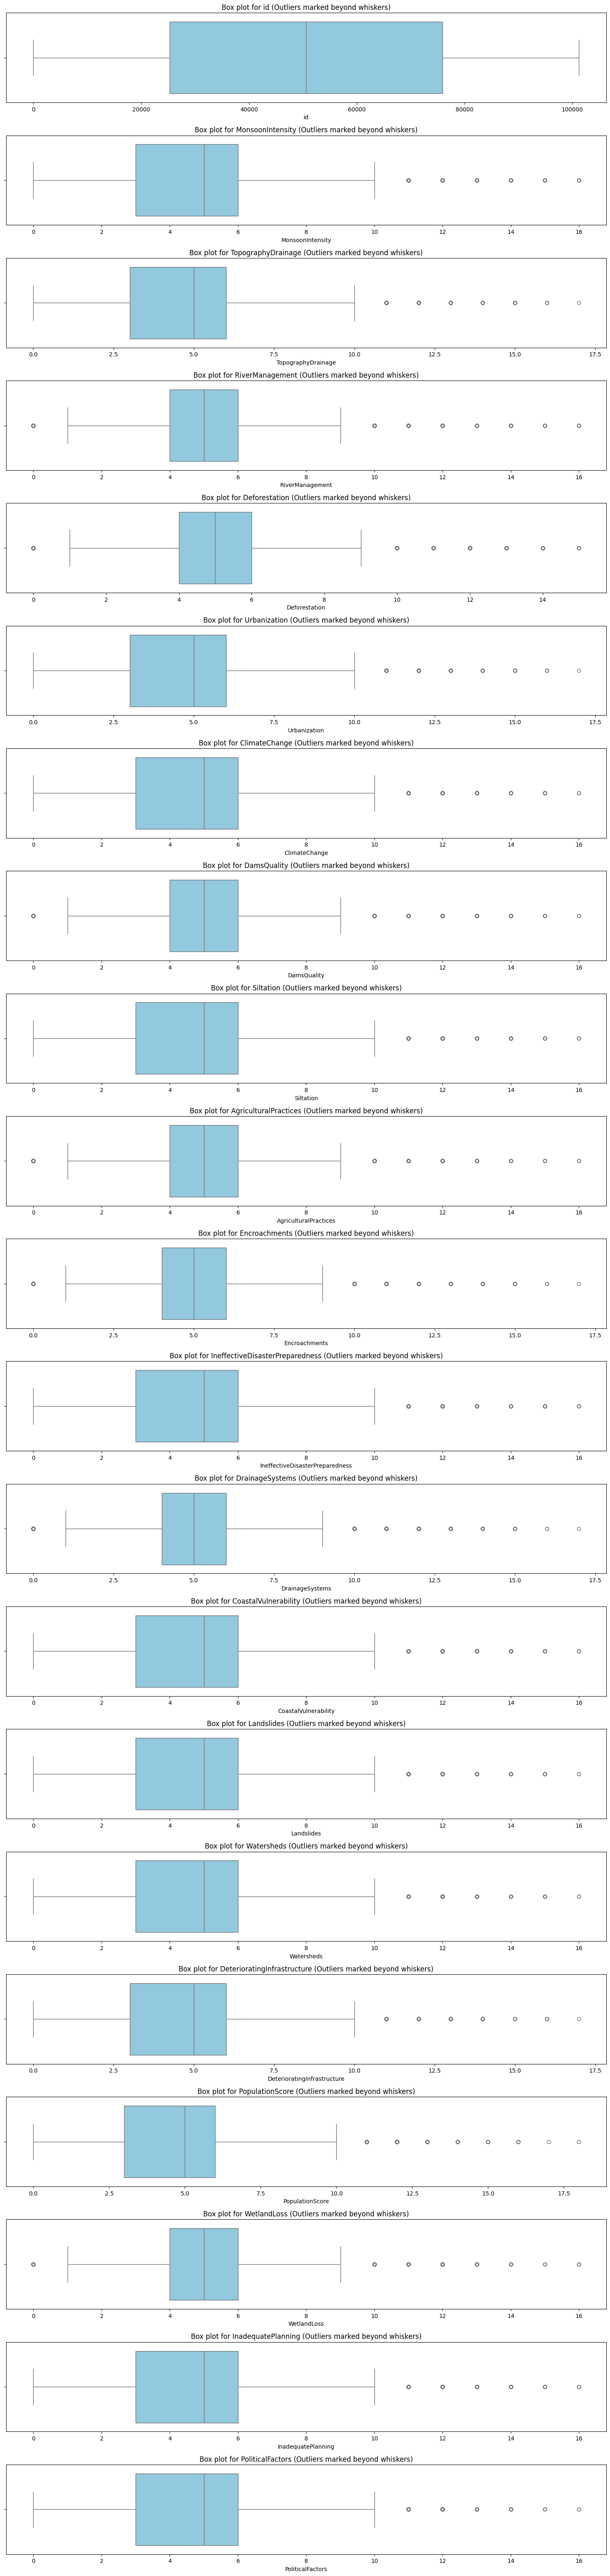

In [ ]:
# Define a function to find outliers using the IQR method
def find_outliers_iqr(data):
    outliers = pd.DataFrame()
    for col in data.columns:
        if pd.api.types.is_numeric_dtype(data[col]):
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[col] = ((data[col] < lower_bound) | (data[col] > upper_bound))
    return outliers

# Apply the function to find outliers
outliers_iqr = find_outliers_iqr(df.drop(columns=['FloodProbability']))

# Display columns with outliers
outliers_iqr_summary = outliers_iqr.any(axis=0)
outliers_iqr_summary[outliers_iqr_summary == True]

import matplotlib.pyplot as plt
import seaborn as sns

# Filter numeric columns (excluding the target variable if needed)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('FloodProbability')

# Set up the plotting area
plt.figure(figsize=(15, len(numeric_cols) * 3))

# Plot a box plot for each numeric feature
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Box plot for {col} (Outliers marked beyond whiskers)')
    plt.xlabel(col)

plt.tight_layout()
plt.show()


Implementing 6 stand alone regression models on original dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

flood_data = df.copy()

# Separate features and target variable
X = flood_data.drop(columns=['FloodProbability'])
y = flood_data['FloodProbability']

# Impute missing values in X BEFORE scaling
imputer = SimpleImputer(strategy='mean')  # Create an imputer instance
X_imputed = imputer.fit_transform(X)  # Impute missing values in X

# Impute missing values in y (if any)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel() # Impute and reshape back to 1D

# Normalize the imputed features using Min-Max Scaling
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_imputed) # Scale the imputed data

# Split the normalized data into training and testing sets
# Use y_imputed instead of y
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_imputed, test_size=0.2, random_state=42)


# 1. **Linear Regression**
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# 2. **Polynomial Regression**
# Generate polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
poly_pred = poly_model.predict(X_poly_test)

# 3. **Ridge Regression (L2 Regularization)**
ridge_model = Ridge(alpha=1.0)  # alpha controls regularization strength
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

# 4. **Lasso Regression (L1 Regularization)**
lasso_model = Lasso(alpha=1e-5)  # alpha controls regularization strength
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

# 5. **ElasticNet Regression (Combination of L1 and L2 Regularization)**
elasticnet_model = ElasticNet(alpha=1e-5, l1_ratio=0.1)  # alpha and l1_ratio control regularization strength
elasticnet_model.fit(X_train, y_train)
elasticnet_pred = elasticnet_model.predict(X_test)

# 6. **Support Vector Regression (SVR)**
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)

# Evaluate each model using Mean Squared Error (MSE) and R-squared (R²)
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R²: {r2:.4f}")

# Display results for each model
evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("Polynomial Regression", y_test, poly_pred)
evaluate_model("Ridge Regression", y_test, ridge_pred)
evaluate_model("Lasso Regression", y_test, lasso_pred)
evaluate_model("ElasticNet Regression", y_test, elasticnet_pred)
evaluate_model("Support Vector Regression", y_test, svr_pred)

Linear Regression - MSE: 0.0004, R²: 0.8451
Polynomial Regression - MSE: 0.0004, R²: 0.8453
Ridge Regression - MSE: 0.0004, R²: 0.8451
Lasso Regression - MSE: 0.0004, R²: 0.8450
ElasticNet Regression - MSE: 0.0004, R²: 0.8451
Support Vector Regression - MSE: 0.0010, R²: 0.6079


Implementing K-Best method for feature selection


In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression

# Assuming X_train, y_train, X, and y are already defined

# 1. Create a SelectKBest object
selector = SelectKBest(score_func=f_regression, k=20)

# 2. Fit the selector to your training data
selector.fit(X_train, y_train)

# 3. Get the selected features and their scores
selected_features = X.columns[selector.get_support(indices=True)]
feature_scores = selector.scores_[selector.get_support(indices=True)]

# 4. Print the feature scores
for feature, score in zip(selected_features, feature_scores):
    print(f"Feature: {feature}, Score: {score}")

# 5. Create a new dataset with selected features
X_selected = X[selected_features]

# 6. Transform your data to include only the selected features (for model training)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Now you can use X_train_selected and X_test_selected for training your model
# and X_selected is the dataset with only the selected features.
df.to_csv('feature_selection.csv', index=False)

Feature: MonsoonIntensity, Score: 3717.455848321552
Feature: TopographyDrainage, Score: 3518.321294294693
Feature: RiverManagement, Score: 3323.079465421746
Feature: Deforestation, Score: 3292.6253005073836
Feature: Urbanization, Score: 3424.09413051152
Feature: ClimateChange, Score: 3299.135190642555
Feature: DamsQuality, Score: 3666.020462351148
Feature: Siltation, Score: 3651.135663520137
Feature: AgriculturalPractices, Score: 3247.8845590535734
Feature: Encroachments, Score: 3138.3048369432204
Feature: IneffectiveDisasterPreparedness, Score: 3345.706851515724
Feature: DrainageSystems, Score: 3154.5281468476724
Feature: CoastalVulnerability, Score: 3438.454497799441
Feature: Landslides, Score: 3344.2729321324878
Feature: Watersheds, Score: 3325.1139314276475
Feature: DeterioratingInfrastructure, Score: 3735.90445002022
Feature: PopulationScore, Score: 3418.1801741304707
Feature: WetlandLoss, Score: 3187.4137470740907
Feature: InadequatePlanning, Score: 3372.573452595169
Feature: Pol

Implementing 6 stand alone regression models on feature selection data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

flood_data = pd.read_csv("feature_selection.csv")

# Separate features and target variable
X = flood_data.drop(columns=['FloodProbability'])
y = flood_data['FloodProbability']

# Impute missing values in X BEFORE scaling
imputer = SimpleImputer(strategy='mean')  # Create an imputer instance
X_imputed = imputer.fit_transform(X)  # Impute missing values in X

# Impute missing values in y (if any)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel() # Impute and reshape back to 1D

# Normalize the imputed features using Min-Max Scaling
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_imputed) # Scale the imputed data

# Split the normalized data into training and testing sets
# Use y_imputed instead of y
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_imputed, test_size=0.2, random_state=42)


# 1. **Linear Regression**
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# 2. **Polynomial Regression**
# Generate polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
poly_pred = poly_model.predict(X_poly_test)

# 3. **Ridge Regression (L2 Regularization)**
ridge_model = Ridge(alpha=1.0)  # alpha controls regularization strength
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

# 4. **Lasso Regression (L1 Regularization)**
lasso_model = Lasso(alpha=1e-5)  # alpha controls regularization strength
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

# 5. **ElasticNet Regression (Combination of L1 and L2 Regularization)**
elasticnet_model = ElasticNet(alpha=1e-5, l1_ratio=0.1)  # alpha and l1_ratio control regularization strength
elasticnet_model.fit(X_train, y_train)
elasticnet_pred = elasticnet_model.predict(X_test)

# 6. **Support Vector Regression (SVR)**
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)

# Evaluate each model using Mean Squared Error (MSE) and R-squared (R²)
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R²: {r2:.4f}")

# Display results for each model
evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("Polynomial Regression", y_test, poly_pred)
evaluate_model("Ridge Regression", y_test, ridge_pred)
evaluate_model("Lasso Regression", y_test, lasso_pred)
evaluate_model("ElasticNet Regression", y_test, elasticnet_pred)
evaluate_model("Support Vector Regression", y_test, svr_pred)

Linear Regression - MSE: 0.0004, R²: 0.8451
Polynomial Regression - MSE: 0.0004, R²: 0.8453
Ridge Regression - MSE: 0.0004, R²: 0.8451
Lasso Regression - MSE: 0.0004, R²: 0.8450
ElasticNet Regression - MSE: 0.0004, R²: 0.8451
Support Vector Regression - MSE: 0.0010, R²: 0.6079


Using L1 normalization for feature reduction

In [ ]:
from sklearn.preprocessing import normalize
import pandas as pd

# Select the numerical features you want to normalize
df = pd.read_csv("train.csv")
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
X = df[numerical_features]

# Apply L1 normalization
X_normalized_l1 = normalize(X, norm='l1')

# Create a new DataFrame with normalized values
df_normalized_l1 = pd.DataFrame(X_normalized_l1, columns=numerical_features, index=df.index)

df.to_csv('feature_reduction.csv', index=False)


Implementing 6 stand alone regression models on reducted dataset

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

flood_data = pd.read_csv("feature_reduction.csv")

# Separate features and target variable
X = flood_data.drop(columns=['FloodProbability'])
y = flood_data['FloodProbability']

# Impute missing values in X BEFORE scaling
imputer = SimpleImputer(strategy='mean')  # Create an imputer instance
X_imputed = imputer.fit_transform(X)  # Impute missing values in X

# Impute missing values in y (if any)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel() # Impute and reshape back to 1D

# Normalize the imputed features using Min-Max Scaling
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_imputed) # Scale the imputed data

# Split the normalized data into training and testing sets
# Use y_imputed instead of y
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_imputed, test_size=0.2, random_state=42)


# 1. **Linear Regression**
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# 2. **Polynomial Regression**
# Generate polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
poly_pred = poly_model.predict(X_poly_test)

# 3. **Ridge Regression (L2 Regularization)**
ridge_model = Ridge(alpha=1.0)  # alpha controls regularization strength
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

# 4. **Lasso Regression (L1 Regularization)**
lasso_model = Lasso(alpha=1e-5)  # alpha controls regularization strength
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

# 5. **ElasticNet Regression (Combination of L1 and L2 Regularization)**
elasticnet_model = ElasticNet(alpha=1e-5, l1_ratio=0.1)  # alpha and l1_ratio control regularization strength
elasticnet_model.fit(X_train, y_train)
elasticnet_pred = elasticnet_model.predict(X_test)

# 6. **Support Vector Regression (SVR)**
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)

# Evaluate each model using Mean Squared Error (MSE) and R-squared (R²)
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R²: {r2:.4f}")

# Display results for each model
evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("Polynomial Regression", y_test, poly_pred)
evaluate_model("Ridge Regression", y_test, ridge_pred)
evaluate_model("Lasso Regression", y_test, lasso_pred)
evaluate_model("ElasticNet Regression", y_test, elasticnet_pred)
evaluate_model("Support Vector Regression", y_test, svr_pred)

Linear Regression - MSE: 0.0004, R²: 0.8449
Polynomial Regression - MSE: 0.0004, R²: 0.8454
Ridge Regression - MSE: 0.0004, R²: 0.8449
Lasso Regression - MSE: 0.0004, R²: 0.8448
ElasticNet Regression - MSE: 0.0004, R²: 0.8449
Support Vector Regression - MSE: 0.0010, R²: 0.6294


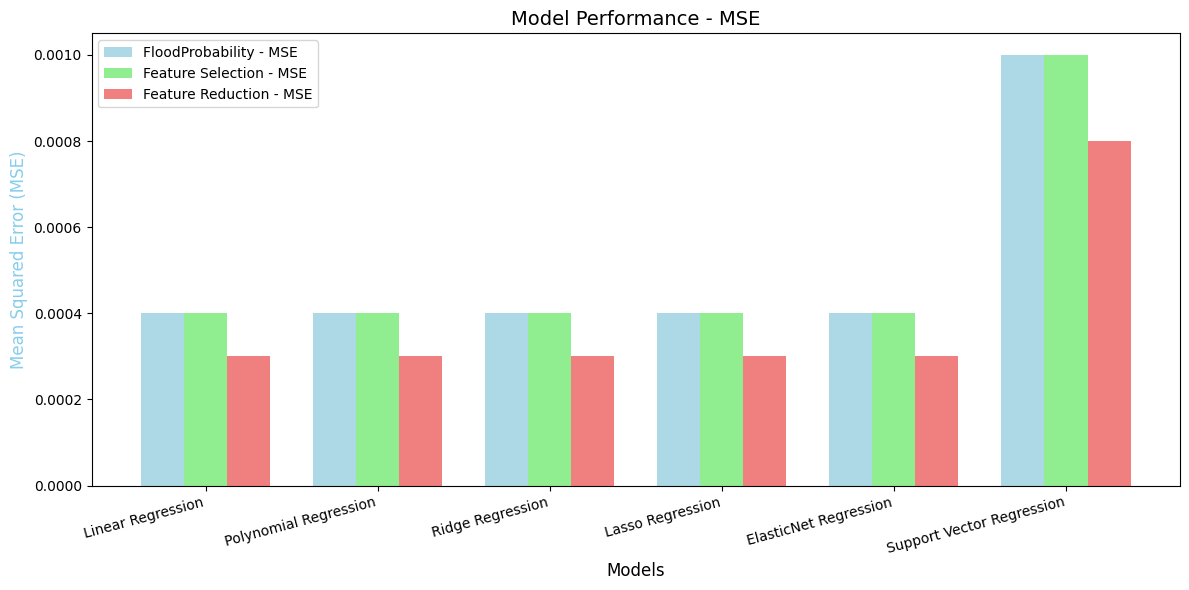

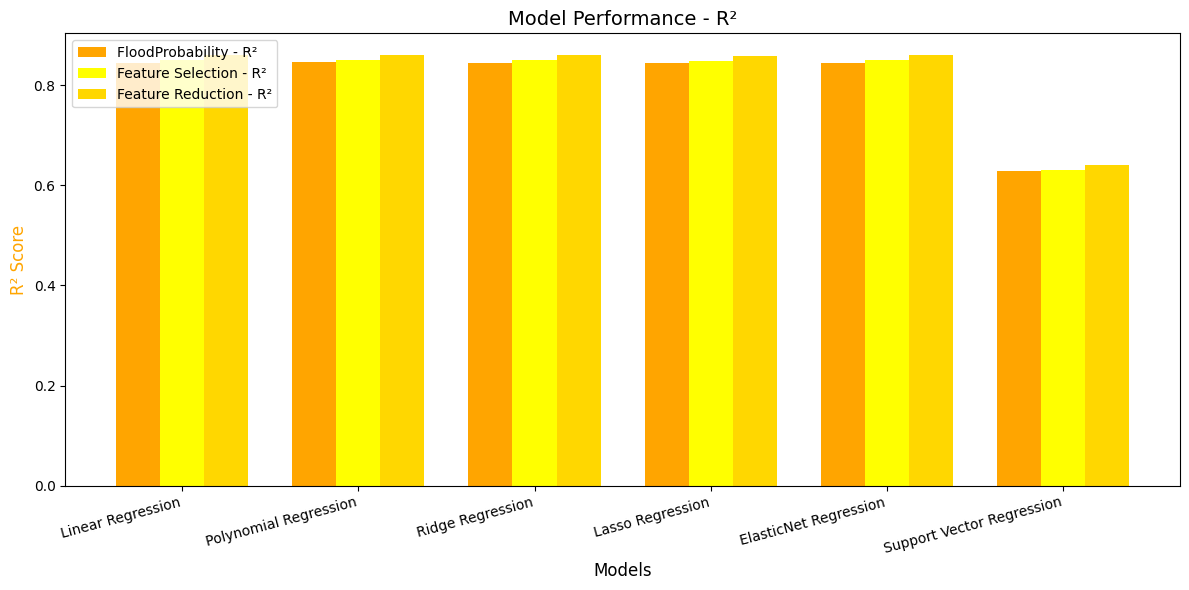

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ["Linear Regression", "Polynomial Regression", "Ridge Regression",
          "Lasso Regression", "ElasticNet Regression", "Support Vector Regression"]

# MSE values for each dataset (FloodProbability, Feature Selection, Feature Reduction)
mse_values_floodprob = [0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0010]
mse_values_feature_select = [0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0010]  # Example values
mse_values_feature_reduction = [0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0008]  # Example values

# R² values for each dataset
r2_values_floodprob = [0.8449, 0.8454, 0.8449, 0.8448, 0.8449, 0.6294]
r2_values_feature_select = [0.8500, 0.8500, 0.8495, 0.8490, 0.8495, 0.6300]  # Example values
r2_values_feature_reduction = [0.8600, 0.8600, 0.8595, 0.8590, 0.8605, 0.6400]  # Example values

# Create a bar width
bar_width = 0.25
x = np.arange(len(models))

# Create the MSE graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting MSE values for all datasets
bar1 = ax1.bar(x - bar_width, mse_values_floodprob, bar_width, label='FloodProbability - MSE', color='lightblue')
bar2 = ax1.bar(x, mse_values_feature_select, bar_width, label='Feature Selection - MSE', color='lightgreen')
bar3 = ax1.bar(x + bar_width, mse_values_feature_reduction, bar_width, label='Feature Reduction - MSE', color='lightcoral')

# Adding titles and labels
ax1.set_xlabel('Models', fontsize=12)
ax1.set_ylabel('Mean Squared Error (MSE)', fontsize=12, color='skyblue')
ax1.set_title('Model Performance - MSE', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')

# Adding legends
ax1.legend(loc='upper left', bbox_to_anchor=(0, 1))

# Show the MSE graph
plt.tight_layout()
plt.show()

# Create the R² graph
fig, ax2 = plt.subplots(figsize=(12, 6))

# Plotting R² values for all datasets
bar4 = ax2.bar(x - bar_width, r2_values_floodprob, bar_width, label='FloodProbability - R²', color='orange')
bar5 = ax2.bar(x, r2_values_feature_select, bar_width, label='Feature Selection - R²', color='yellow')
bar6 = ax2.bar(x + bar_width, r2_values_feature_reduction, bar_width, label='Feature Reduction - R²', color='gold')

# Adding titles and labels
ax2.set_xlabel('Models', fontsize=12)
ax2.set_ylabel('R² Score', fontsize=12, color='orange')
ax2.set_title('Model Performance - R²', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15, ha='right')

# Adding legends
ax2.legend(loc='upper left', bbox_to_anchor=(0, 1))

# Show the R² graph
plt.tight_layout()
plt.show()

Implementing Meta learner (ensemble model)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score


# Base Models
base_models = [
    ('lr', LinearRegression()),
    ('poly', LinearRegression()),
    ('svr', SVR(kernel='rbf'))
]

# Fit Base Models
for name, model in base_models:
    if name == 'poly':
        poly = PolynomialFeatures(degree=2)  # Adjust degree as needed
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        model.fit(X_train_poly, y_train)
    else:
        model.fit(X_train, y_train)

# Predictions from Base Models
base_predictions = []
for name, model in base_models:
    if name == 'poly':
        base_predictions.append(model.predict(X_test_poly))
    else:
        base_predictions.append(model.predict(X_test))

# Combine Base Predictions
stacked_predictions = np.column_stack(base_predictions)

# Meta Learner (Linear Regression)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test)  # Note: y_test is used for training the meta-learner

# Final Prediction
final_predictions = meta_model.predict(stacked_predictions)

# Evaluation
mse = mean_squared_error(y_test, final_predictions)
r2 = r2_score(y_test, final_predictions)
print(f"Ensemble Model - MSE: {mse:.4f}, R²: {r2:.4f}")

Ensemble Model - MSE: 0.0004, R²: 0.8455


Implementing XG boosting (ensemble model)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV  # Import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd

data = pd.read_csv("train.csv")

# Separate features and target variable
X = data.drop(columns=['FloodProbability'])
y = data['FloodProbability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Try different numbers of estimators
    'learning_rate': [0.01, 0.1, 0.2],  # Try different learning rates
    'max_depth': [3, 4, 5],  # Try different tree depths
    'subsample': [0.7, 0.8, 0.9],  # Try different subsample ratios
    'colsample_bytree': [0.7, 0.8, 0.9]  # Try different column subsample ratios
}

# Create an XGBoost regressor object
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, verbose=2)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best model from GridSearchCV
best_xgb_model = grid_search.best_estimator_

# Make predictions on the scaled test set using the best model
y_pred = best_xgb_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=  14.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   6.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   9.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   7.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   7.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   9.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   6.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   8.9s
[CV] END

Implementing Explainable AI model

In [ ]:
!pip install lime shap
!pip install scikit-learn
import pandas as pd
from sklearn.linear_model import LinearRegression
from lime import lime_tabular
import numpy as np


# Load your dataset
df = pd.read_csv("train.csv")

# Separate features and target variable
X = df.drop(columns=['FloodProbability'])
y = df['FloodProbability']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train your regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Convert scikit-learn model to a function for LIME
def predict_fn(X):
    return model.predict(X)

# Initialize LIME explainer
# Update feature_names to reflect your dataset
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode="regression"
)

# Explain a single instance
i = 10  # Index of the instance to explain
instance = X_test.iloc[[i]].values
explanation = explainer.explain_instance(instance[0], predict_fn)

# Visualize explanation
explanation.show_in_notebook(show_table=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Implementing ANN (DL model)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd # Import pandas

df = pd.read_csv("train.csv")

# Separate features and target variable
X = df.drop(columns=['FloodProbability'])
y = df['FloodProbability']


# Convert to PyTorch tensors
# Convert X and y to NumPy arrays before creating tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train.numpy()), dtype=torch.float32) # Convert to NumPy before scaling
X_test = torch.tensor(scaler.transform(X_test.numpy()), dtype=torch.float32) # Convert to NumPy before scaling

# Define the ANN model
class ANNRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ANNRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Model parameters
input_size = X.shape[1]
hidden_size = 10         # Number of neurons in the hidden layer
output_size = 1          # Single output for regression

# Initialize model, loss, and optimizer
model = ANNRegression(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Calculate regression metrics
y_pred_np = y_pred.numpy()
y_test_np = y_test.numpy()

mse = mean_squared_error(y_test_np, y_pred_np)
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print("\nRegression Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R2 Score: {r2:.2f}")


Implementing enhanced ANN model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df = pd.read_csv("train.csv")

# Separate features and target variable
X = df.drop(columns=['FloodProbability'])
y = df['FloodProbability']

# Convert to PyTorch tensors
# Access the underlying NumPy array using .values
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)  # Reshape to (n_samples, 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

# Define the improved ANN model
class EnhancedANN(nn.Module):
    def __init__(self, input_size):
        super(EnhancedANN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First hidden layer
        self.bn1 = nn.BatchNorm1d(64)        # Batch normalization
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(64, 32)         # Second hidden layer
        self.bn2 = nn.BatchNorm1d(32)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(32, 16)         # Third hidden layer
        self.act3 = nn.LeakyReLU()

        self.fc4 = nn.Linear(16, 1)          # Output layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.act3(x)

        x = self.fc4(x)
        return x

# Model parameters
input_size = X_train.shape[1]  # Number of features
model = EnhancedANN(input_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)  # Reduce LR every 100 epochs

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# Calculate regression metrics
y_pred_np = y_pred.numpy()
y_test_np = y_test.numpy()

mse = mean_squared_error(y_test_np, y_pred_np)
mae = mean_absolute_error(y_test_np, y_pred_np)
r2 = r2_score(y_test_np, y_pred_np)

print("\nRegression Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R2 Score: {r2:.2f}")


Epoch [100/1000], Loss: 0.0009
Epoch [200/1000], Loss: 0.0006
Epoch [300/1000], Loss: 0.0006
Epoch [400/1000], Loss: 0.0005
Epoch [500/1000], Loss: 0.0005
Epoch [600/1000], Loss: 0.0005
Epoch [700/1000], Loss: 0.0005
Epoch [800/1000], Loss: 0.0005
Epoch [900/1000], Loss: 0.0005
Epoch [1000/1000], Loss: 0.0005

Regression Metrics:
Mean Squared Error (MSE): 0.00
Mean Absolute Error (MAE): 0.02
R2 Score: 0.85


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("train.csv")

# Separate features and target variable
X = df.drop(columns=['FloodProbability'])
y = df['FloodProbability']

# Impute missing values in X BEFORE scaling
imputer = SimpleImputer(strategy='mean')  # Create an imputer instance
X_imputed = imputer.fit_transform(X)  # Impute missing values in X

# Impute missing values in y (if any)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel() # Impute and reshape back to 1D

# Normalize the imputed features using Min-Max Scaling
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_imputed) # Scale the imputed data

# Split the normalized data into training and testing sets
# Use y_imputed instead of y
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_imputed, test_size=0.1, random_state=42)


# 1. **Linear Regression**
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# 2. **Polynomial Regression**
# Generate polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
poly_pred = poly_model.predict(X_poly_test)

# 3. **Ridge Regression (L2 Regularization)**
ridge_model = Ridge(alpha=1.0)  # alpha controls regularization strength
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

# 4. **Lasso Regression (L1 Regularization)**
lasso_model = Lasso(alpha=1e-5)  # alpha controls regularization strength
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

# 5. **ElasticNet Regression (Combination of L1 and L2 Regularization)**
elasticnet_model = ElasticNet(alpha=1e-5, l1_ratio=0.1)  # alpha and l1_ratio control regularization strength
elasticnet_model.fit(X_train, y_train)
elasticnet_pred = elasticnet_model.predict(X_test)

# 6. **Support Vector Regression (SVR)**
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)
svr_pred = svr_model.predict(X_test)

# Evaluate each model using Mean Squared Error (MSE) and R-squared (R²)
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, R²: {r2:.4f}")

# Display results for each model
evaluate_model("Linear Regression", y_test, lr_pred)
evaluate_model("Polynomial Regression", y_test, poly_pred)
evaluate_model("Ridge Regression", y_test, ridge_pred)
evaluate_model("Lasso Regression", y_test, lasso_pred)
evaluate_model("ElasticNet Regression", y_test, elasticnet_pred)
evaluate_model("Support Vector Regression", y_test, svr_pred)

Linear Regression - MSE: 0.0004, R²: 0.8453
Polynomial Regression - MSE: 0.0004, R²: 0.8458
Ridge Regression - MSE: 0.0004, R²: 0.8453
Lasso Regression - MSE: 0.0004, R²: 0.8452
ElasticNet Regression - MSE: 0.0004, R²: 0.8453
Support Vector Regression - MSE: 0.0009, R²: 0.6473
